In [55]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
import codecs
from sklearn import linear_model
import numpy.ma as ma
from matplotlib.mlab import PCA
from sklearn.utils import shuffle
%matplotlib inline  
DEFAULT_DPI = 600
matplotlib.rcParams['figure.figsize'] = (15, 8)
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC, AdaBoostClassifier as ABC
from sklearn.metrics import precision_recall_curve

In [47]:
# load data
df_learn = pd.DataFrame(np.zeros(shape=[9154, 140]))
file = open('dataset_16_3_learn', encoding="utf8")
df_learn.loc[0] = pd.Series(np.arange(140))
ind = 1
for line in file.readlines():    
    splitted_line = np.array(line.split(), dtype=np.str)       
    if len(splitted_line) != 140:
        print('Bad index:', ind, len(splitted_line), splitted_line)    
    df_learn.loc[ind] = pd.Series(splitted_line)
    ind += 1

In [48]:
# load data
data = pd.DataFrame(np.zeros(shape=[3728, 139]))
file = open('dataset_16_3_test', encoding="utf8")
data.loc[0] = pd.Series(np.arange(139))
ind = 1
for line in file.readlines():    
    splitted_line = np.array(line.split(), dtype=np.str)       
    if len(splitted_line) != 139:
        print('Bad index:', ind, len(splitted_line), splitted_line)    
    data.loc[ind] = pd.Series(splitted_line)
    ind += 1


In [49]:
test_data = np.array(df_test).T
data = np.array(df_learn).T
hash_columns = data[:2, 1:]
is_fraud_user = data[2, 1:]
test_hash_columns = test_data[:2, 1:]

In [50]:
data = data[3:]
init_data = data.copy()
ncols -= 3
test_data = test_data[2:]

## Обработка данных

In [51]:
to_delete = []
for row in range(ncols):
    unique, counts = np.unique(np.array(data[row,:], dtype=np.str), return_counts=True)
    d = dict(zip(unique, counts))        
    ratio =  d.get('-', 0)
    if ratio > 0 or len(d) == 1:
        to_delete.append(row)

In [52]:
data = scipy.delete(data, to_delete, 0)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """Entry point for launching an IPython kernel.


Посмотрим на скоррелированность, и будем удалять столбцы, пока будут скоррелированы  

In [53]:
while True:
    f = True
    c = np.corrcoef(np.array(data, dtype = np.float))
    for i in range(data.shape[0]):
        for j in range(i + 1, data.shape[0]):
            if abs(c[i, j]) >  0.7:
                f = False
                res= j
                break
    if not f:
        bad_cols.append(res)
        data = scipy.delete(data, res, 0)
        break

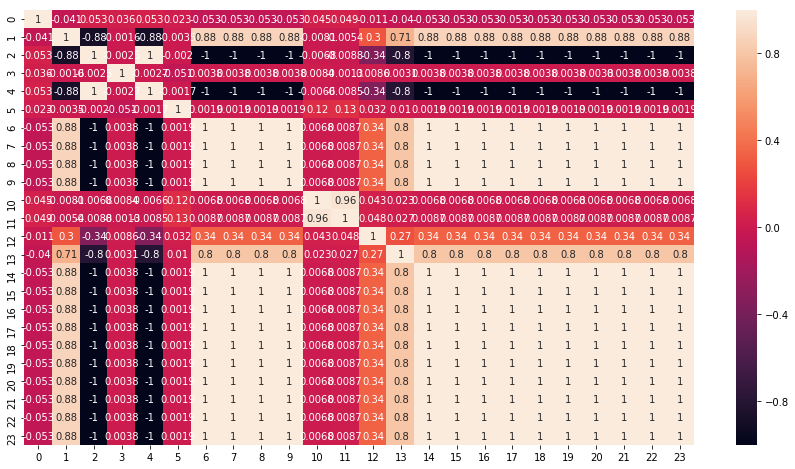

In [56]:
#visualization
ax = plt.axes()
sns.heatmap(np.corrcoef(np.array(data, dtype = np.float)), annot=True, ax=ax)

Удалим фиктивную строку с номером столбца

In [9]:
data = data[:, 1:]
test_data = test_data[:, 1:]

### Применим PCA
аналогично заданию 2

In [11]:
new_data = np.array(data.T, dtype=np.float)
pca1 = PCA(new_data, standardize=True)

print ("Explained variance")
for d in pca1.fracs:
    print (d)

Explained variance
0.167786719393
0.109802209547
0.103304679888
0.100001292863
0.0997454972674
0.0975226806437
0.0935690766154
0.089953488325
0.0822613030153
0.0560530524421


Получаем, что PCA можно не применять 

## Задаим только один  классификатор, это будет random forest

In [ ]:
def split_train_test(features, labels):
    N_learn = (2 * features.shape[0] // 3)
    learn_features = features[:N_learn]
    test_features =  features[N_learn:]
    learn_labels = labels[:N_learn]
    test_labels =  labels[N_learn:]
    return learn_features, test_features, learn_labels, test_labels

In [14]:
features, labels = shuffle(data, np.array(is_fraud_user, dtype=np.float))

In [15]:
def RFC_tuning(features, labels):
    max_features_list = ['auto', 'sqrt', 0.25]
    n_estimators_list = [1, 5, 10]
    min_samples_leaf_list = [1, 5, 20]
    names_list = ["precision", "recall", "max_features", "n_estimators", "min_samples_leaf"]
    max_f1 = 0
    res_list = []
    for max_features in max_features_list:
        for n_estimators in n_estimators_list:
            for min_samples_leaf in min_samples_leaf_list:
                cur_method = RFC(max_features=max_features, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)            
                learn_features, test_features, learn_labels, test_labels = split_train_test(features, labels)
                cur_method.fit(learn_features, learn_labels)
                predict = cur_method.predict(features)
                if np.sum(predict) == 0 or np.sum(labels) == 0:
                    prec, recall, f1 = 0, 0, 0
                prec = np.sum(predict*labels)/(np.sum(predict)+.0)
                recall = np.sum(predict*labels)/(np.sum(labels)+.0)
                f1 = 2*prec*recall/(prec+recall)
                if f1 > max_f1:
                    max_f1 = f1                
                    res_list = [precision, recall, max_features, n_estimators, min_samples_leaf]
    print('Best RFC by F1:')            
    print(max_f1, list(zip(names_list, res_list)))
RFC_tuning(features, labels)

Best RFC by F1:
0.720951509607 [('precision', 0.57568673290473404), ('recall', 0.96426823299069997), ('max_features', 'sqrt'), ('n_estimators', 10), ('min_samples_leaf', 20)]


## Обработка пропусков

Итак, нам нужно чем-то заменить пропуски. 
Проверим гипотезу, что нужно заменять все 0.

Заметим, что правим только 0, 1 и 23 столбец.

In [60]:
gaps_column = [0, 1, 23]

In [61]:
def fill(s):
    dict = {'-':num, '':num}
    if s in dict.keys():
        return dict[s]
    else:
        return float(s)

In [65]:
data_g = []
gaps_d = []
for num in gaps_column:
    current_data = init_data.copy()
    f = np.vectorize(fill)
    current_data = f(current_data).T[1:, ]
    to_delete = []
    for i in range(current_data.shape[1]):
        unique, counts = np.unique(current_data[:, i], return_counts=True)
        if len(unique) == 1:
            to_delete.append(i)
    gaps_d.append(to_delete)
    current_data = scipy.delete(current_data, to_delete, 1)
    corr_array = np.corrcoef(np.array(current_data.T, dtype = np.float))
    data_g.append(current_data)
    init_features, init_labels = shuffle(current_data, np.array(is_fraud_user, dtype=np.float))
    RFC_tuning(init_features, init_labels)

Best RFC by F1:
0.722578282366 [('precision', 0.57723815096547693), ('recall', 0.96573666177190409), ('max_features', 'auto'), ('n_estimators', 5), ('min_samples_leaf', 20)]
Best RFC by F1:
0.974234321828 [('precision', 0.96764847899565432), ('recall', 0.98091042584434651), ('max_features', 0.25), ('n_estimators', 10), ('min_samples_leaf', 1)]
Best RFC by F1:
0.974358974359 [('precision', 0.96317551410808222), ('recall', 0.98580518844836029), ('max_features', 'auto'), ('n_estimators', 5), ('min_samples_leaf', 1)]


Видим, что при замене пропусков на 0, значения хуже, чем при замене на что-то еще.

### Тесты

Заполним пропуски и посчитаем что предсказывает random forest

In [66]:
ind = 2
num = gaps_column[ind]

f = np.vectorize(fill)
data = data_g[ind]
labels = np.array(is_fraud_user, dtype=np.float)
test_data = scipy.delete(test_data, gaps_to_delete[ind], 0)
fixed_test_data = f(test_data).T

RFC_best_method = RFC(max_features=0.25, n_estimators=5, min_samples_leaf=1)            
RFC_best_method.fit(data, labels)
RFC_predict = RFC_best_method.predict(fixed_test_data)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  import sys


ValueError: Number of features of the model must match the input. Model n_features is 106 and input n_features is 83 